# Generic Model for Sustainer Program

Building generic model

What's included in this Analysis:
1. Load the libraries
2. Load the dataset
3. Helper function
- 3.1 non-scaling vs. scaling
4. Feature Selection
    -  Logistic Regression
    -  Random Forest
5. Models Training 
    -  Logistic Regression
    -  Random Forest
    -  Model results comparison(lr vs. rf and fslr vs. fsrf)
6. Hyperparameter Tuning
    -  with Logistic Regression
    -  with Random Forest
    -  (lr vs. rf)

## 1. Load the libraries

In [88]:
from pathlib import Path
import pandas as pd
import numpy as np

import itertools
from tqdm import tqdm

from statsmodels.stats.outliers_influence import variance_inflation_factor

import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
sns.set_theme(style="darkgrid")

from sklearn.experimental import enable_iterative_imputer
from sklearn.linear_model import LinearRegression
from sklearn.impute import IterativeImputer, SimpleImputer

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline, Pipeline

from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score, RepeatedStratifiedKFold
from sklearn.feature_selection import RFECV, RFE
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, roc_curve, auc, matthews_corrcoef, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
# from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import IsolationForest
from sklearn.tree import DecisionTreeRegressor

# from sklearn.neural_network import MLPClassifier

## Helper function

In [ ]:

# helper function
def full_path(subdir, fname):
    cwd = cwd = Path.cwd()
    full_path = cwd / subdir / fname
    return full_path

def drop_vars(df, colnames):
    return df[df.columns.difference(colnames)]

# separate data into label and features
def sep_var(df):
    labels = df['sustainer']
    features = df[df.columns.difference(['sustainer'])]
    return features, labels

def calculate_vif(features):
    vif = pd.DataFrame()
    vif["Features"] = features.columns
    vif["VIF"] = [variance_inflation_factor(features.values, i) for i in range(features.shape[1])]    
    return(vif)

# Plot correlations matrix
def corr_graph(df):
    corr = df.corr()
    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(mask)] = True
    # Heatmap
    plt.figure(figsize=(15, 10))
    sns.heatmap(corr,
                vmax=1.0,
                mask=mask,
                annot=True, fmt='.2f',
                linewidths=.2, cmap="YlGnBu")

def metrics(Y_test, y_pred, model_name, X):
    n_fea = X.shape[1]
    acc = accuracy_score(Y_test, y_pred)
    # prec = precision_score(Y_test, y_pred)
    rec = recall_score(Y_test, y_pred)
    # f1 = f1_score(Y_test, y_pred)
    auc = roc_auc_score(Y_test, y_pred)
    mcc = matthews_corrcoef(Y_test, y_pred)


    model_results = pd.DataFrame([[model_name, n_fea, acc, rec, auc, mcc]],
                columns = ['Model', 'Number of Features' ,'Accuracy', 'Recall/Sensitivity', 'Roc_Auc', 'MCC'])
    return model_results

def model_results(clf, clf_name, x_train, y_train, x_test, y_test):
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    results = metrics(y_test, y_pred, clf_name, x_train)
    return results

In [29]:
# get current directory
cwd = Path.cwd()
wo_scaling = 'final_data_wo_outliers_wo_scaling'
w_scaling = 'final_data_wo_outliers_w_scaling'

fname_wo_tr = 'generic_train_wo_outliers_wo_scaling.csv'
fname_wo_t = 'generic_test_wo_outliers_wo_scaling.csv'
fname_w_s_tr = 'generic_train_wo_outliers_w_scaling.csv'
fname_w_s_t = 'generic_test_wo_outliers_w_scaling.csv'

In [52]:
train_wo = pd.read_csv(full_path(wo_scaling, fname_wo_tr))
test_wo = pd.read_csv(full_path(wo_scaling, fname_wo_t))

train_w_s = pd.read_csv(full_path(w_scaling, fname_w_s_tr))
test_w_s = pd.read_csv(full_path(w_scaling, fname_w_s_t))


In [53]:
train_wo.columns

Index(['client', 'sustainer', 'gender', 'client_state_rank', 'all_state_rank',
       'client_zip_rank', 'all_zip_rank', 'age', 'gift_min_t12m',
       'gift_max_t12m', 'gift_avg_t12m', 'gift_count_t12m', 'promo_count_t12m',
       'cons_month_t12m', 'dm_t12m', 'tm_t12m', 'wm_t12m', 'digital_t12m',
       'f2f_t12m', 'events_t12m', 'drtv_t12m', 'other_t12m', 'no_channel_t12m',
       'member_t12m', 'gift_min_lt', 'gift_max_lt', 'gift_avg_lt',
       'gift_count_lt', 'promo_count_lt', 'cons_month_lt'],
      dtype='object')

### Exclued variables for genertic model

In [67]:
ex_vars = ['client', 'client_state_rank', 'client_zip_rank']
# more_vars = ['dm_t12m', 'tm_t12m', 'wm_t12m', 'digital_t12m', 'f2f_t12m', 'events_t12m', 'drtv_t12m', 'other_t12m', 'no_channel_t12m','member_t12m']

In [ ]:
# set_aside_vars = ['drtv_t12m', 'events_t12m', 'f2f_t12m', 'no_channel_t12m', 'tm_t12m']

In [55]:
pd.DataFrame(ex_vars)

,0
0,client
1,client_state_rank
2,client_zip_rank


In [56]:
train_wo = drop_vars(train_wo, ex_vars)
test_wo = drop_vars(test_wo, ex_vars)

train_w_s = drop_vars(train_w_s, ex_vars)
test_w_s = drop_vars(test_w_s, ex_vars)

#### bar plot of scaled data

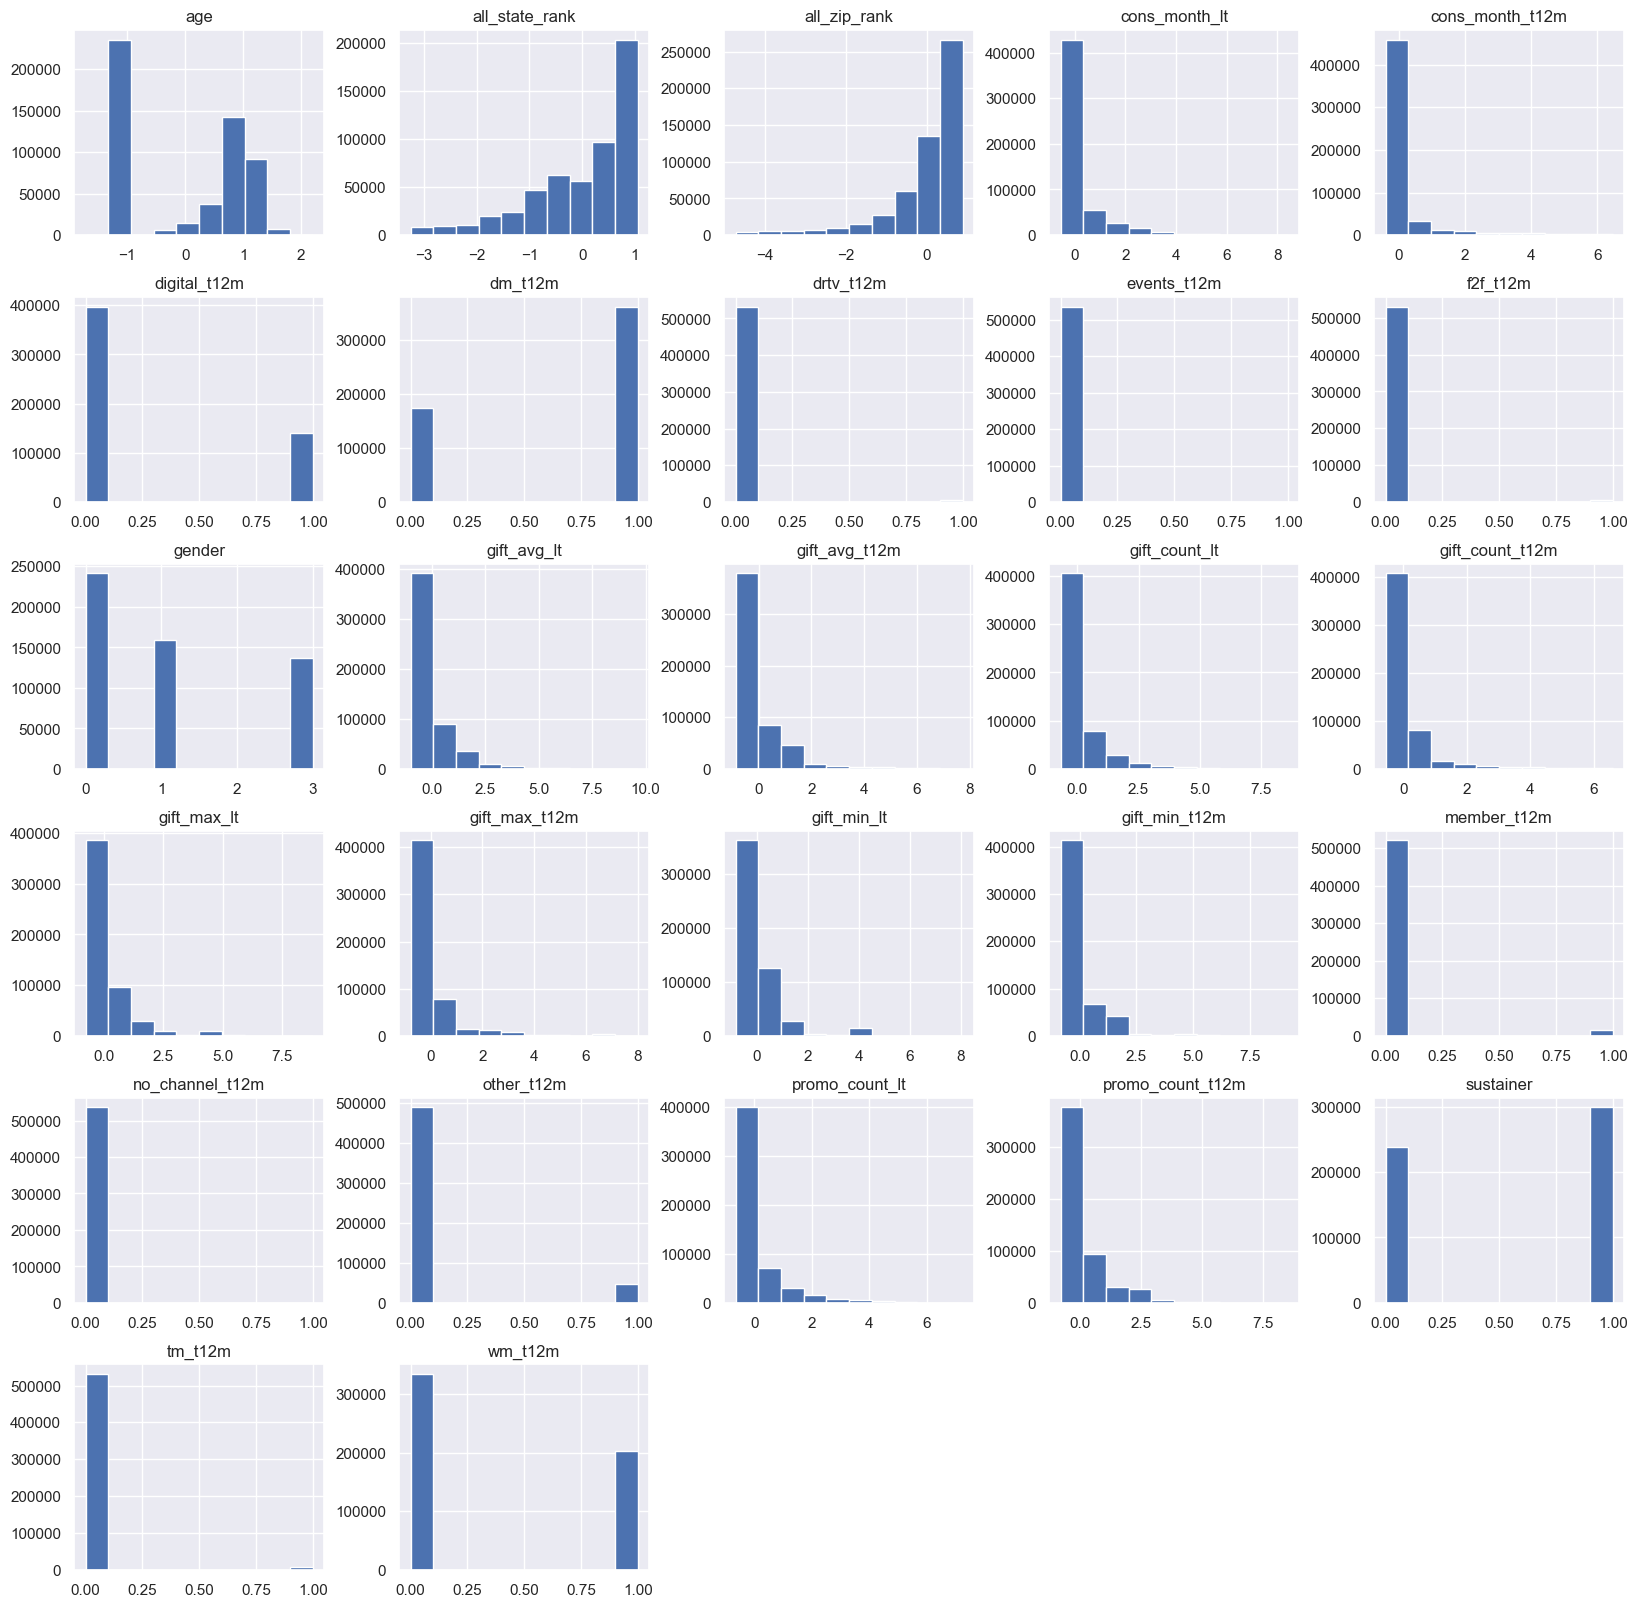

In [66]:
train_w_s.hist(figsize=(20,20))
plt.show()

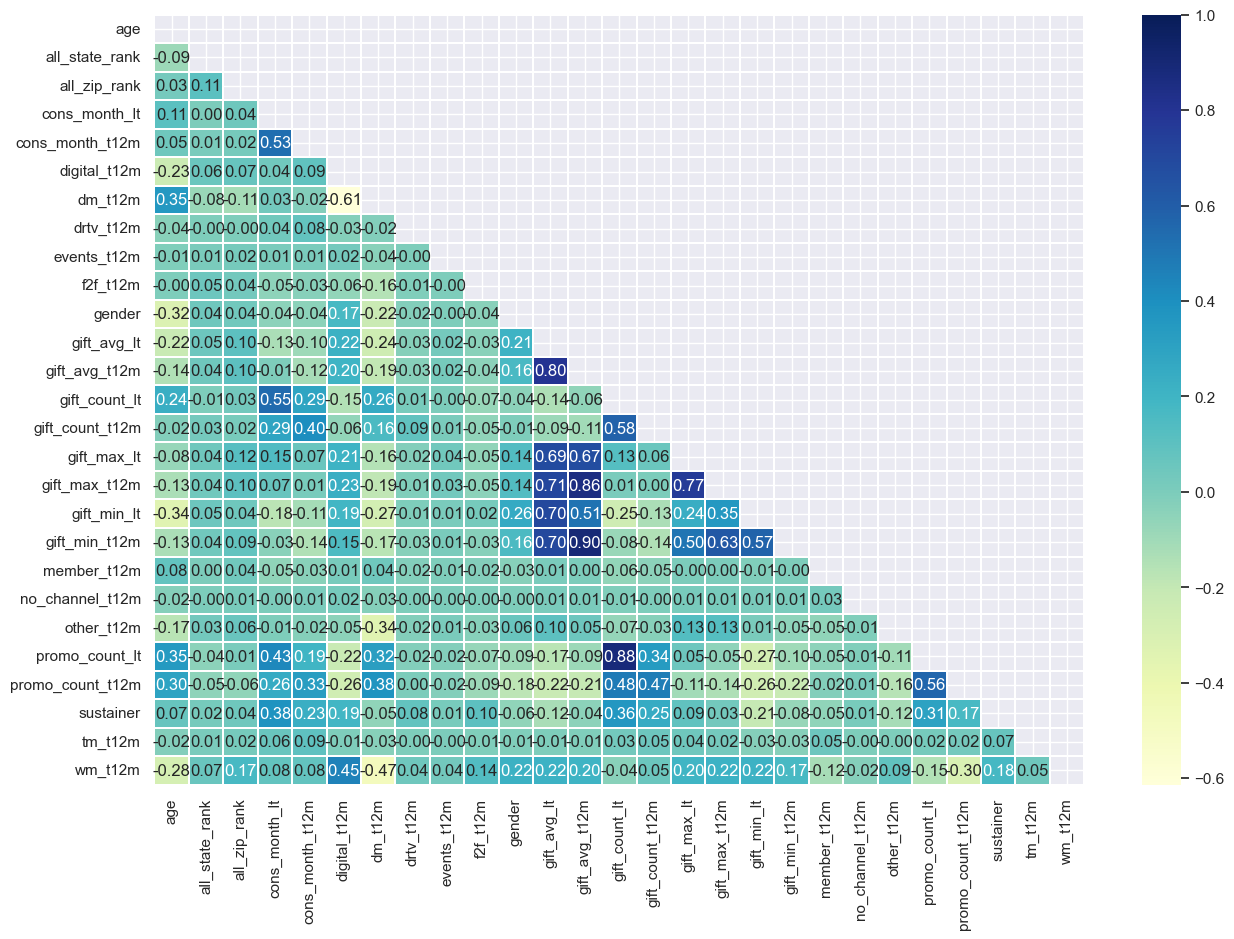

In [80]:
corr_graph(train_w_s)

In [13]:
# sns.set_theme(style="darkgrid")
# df_w_age['age'].plot.hist(figsize=(10,5))

# Machine Learning Models

#### separate X(features) and y(labels)

In [58]:
X_train_wo, y_train_wo = sep_var(train_wo)
X_test_wo, y_test_wo = sep_var(test_wo)

X_train_w_s, y_train_w_s = sep_var(train_w_s)
X_test_w_s, y_test_w_s = sep_var(test_w_s)

### Initial the models

In [74]:
lr = LogisticRegression(random_state=44)
rf = RandomForestClassifier(random_state=44)

####  Scaling vs. non-scaling comparison

In [75]:
lr_all = model_results(lr, 'lr', X_train_wo, y_train_wo, X_test_wo, y_test_wo)
lr_all_w_s = model_results(lr, 'lr_w_s', X_train_w_s, y_train_w_s, X_test_w_s, y_test_w_s)

/Users/qiy/miniconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [77]:
rf_all = model_results(rf, 'rf', X_train_wo, y_train_wo, X_test_wo,y_test_wo)
rf_all_w_s = model_results(rf, 'rf_w_s', X_train_w_s, y_train_w_s, X_test_w_s, y_test_w_s)

MCC metric

https://biodatamining.biomedcentral.com/articles/10.1186/s13040-023-00322-4

In [78]:
pd.concat([lr_all, lr_all_w_s, rf_all, rf_all_w_s], axis=0)

,Model,Number of Features,Accuracy,Recall/Sensitivity,Roc_Auc,MCC
0,lr,26,0.725984,0.690305,0.730580,0.458327
0,lr_w_s,26,0.784613,0.778030,0.785461,0.567911
0,rf,26,0.928390,0.913577,0.930298,0.856773
0,rf_w_s,26,0.928246,0.913499,0.930146,0.856477


### feature selection with RFE with RF (with Scaled data)
- chose lr over rf of rfe 
- https://www.researchgate.net/figure/Feature-selection-for-different-models-by-the-RFE-method-A-LR-B-RF-C-SVM-D_fig4_363879956

In [ ]:
rfe_rf = RFE(rf, n_features_to_select= None)
rfe_rf = rfe_rf.fit(X_train_w_s, y_train_w_s)
# X_train_wo.columns[rfe_rf.support_]

In [86]:
pd.DataFrame(X_train_w_s.columns[rfe_rf.support_])

,0
0,age
1,all_state_rank
2,all_zip_rank
3,cons_month_lt
4,cons_month_t12m
5,digital_t12m
6,gift_avg_lt
7,gift_avg_t12m
8,gift_count_lt
9,gift_max_lt


### feature selection with Tree based method -- extratrees

In [89]:
etc = ExtraTreesClassifier()
etc.fit(X_train_w_s, y_train_w_s)

# print(etc.feature_importances_)

ExtraTreesClassifier()

In [ ]:
importances = etc.feature_importances_
std = np.std([tree.feature_importances_ for tree in etc.estimators_], axis=0)

Elapsed time to compute the importances: 2.831 seconds


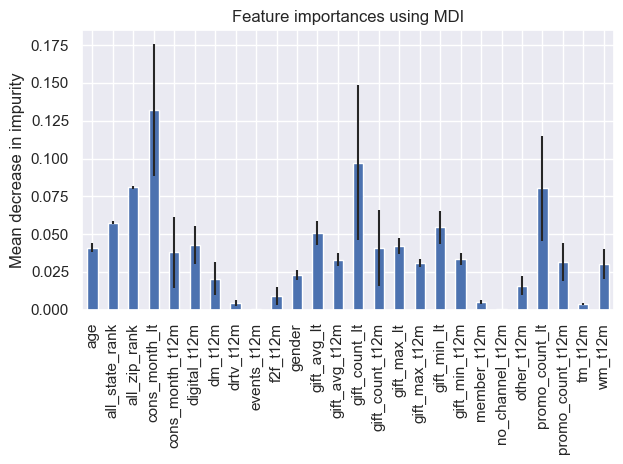

In [96]:
forest_importances = pd.Series(importances, index=X_train_w_s.columns)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [100]:
# from pandas import DataFrame
FI = pd.DataFrame(etc.feature_importances_, columns = ["Extratrees"], index=X_train_w_s.columns)
FI = FI.reset_index()
fi_top13 = FI.sort_values(['Extratrees'],ascending=0).head(13)

In [103]:
etc_feas =fi_top13['index'].to_list()

##  Scaled data with feature selection models comparison

In [104]:
X_train_w_etc = X_train_w_s[etc_feas]
X_test_w_etc = X_test_w_s[etc_feas]
X_train_w_rfe = X_train_w_s[X_train_w_s.columns[rfe_rf.support_]]
X_test_w_rfe = X_test_w_s[X_train_w_s.columns[rfe_rf.support_]]

In [105]:
lr_w_s_etc = model_results(lr, 'lr_w_s_etc', X_train_w_etc, y_train_w_s, X_test_w_etc, y_test_w_s)
lr_w_s_rfe = model_results(lr, 'lr-w_s_rfe', X_train_w_rfe, y_train_w_s, X_test_w_rfe, y_test_w_s)
rf_w_s_rfe = model_results(rf, 'rf_w_s_rfe', X_train_w_rfe, y_train_w_s, X_test_w_rfe, y_test_w_s)
rf_w_s_etc = model_results(rf, 'rf_w_s_etc',X_train_w_etc, y_train_w_s, X_test_w_etc, y_test_w_s)

In [108]:
pd.concat([lr_all_w_s, lr_w_s_etc, lr_w_s_rfe, rf_all_w_s, rf_w_s_etc, rf_w_s_rfe], axis=0)

,Model,Number of Features,Accuracy,Recall/Sensitivity,Roc_Auc,MCC
0,lr_w_s,26,0.784613,0.778030,0.785461,0.567911
0,lr_w_s_etc,13,0.772110,0.763605,0.773206,0.543348
0,lr-w_s_rfe,13,0.771654,0.758691,0.773324,0.543375
0,rf_w_s,26,0.928246,0.913499,0.930146,0.856477
0,rf_w_s_etc,13,0.923092,0.906728,0.925200,0.846375
0,rf_w_s_rfe,13,0.924518,0.909419,0.926463,0.849053


In [81]:
## takes forever to run
# refcv = RFECV(estimator=RandomForestClassifier())
# pipeline = Pipeline(steps=[('Feature Selection',refcv),('Model',rf)])
# # evaluate model
# cv_refcv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=1)
# n_scores = cross_val_score(pipeline, X_train_wo, y_train_wo, scoring='roc_auc', cv=cv_refcv)
# print('Accuracy: %.2f (%.2f)'% (np.mean(n_scores), np.std(n_scores)))

## Hyperparameter tuning for Logistic regression
-lr_w_s_etc utilized here


In [119]:
def solver_pick(X_train, y_train, X_test, y_test, penalty=None):
    clf = [
        LogisticRegression(solver='newton-cg',penalty=penalty,max_iter=1000),
        LogisticRegression(solver='lbfgs',penalty=penalty, max_iter=1000),
        LogisticRegression(solver='sag',penalty=penalty,max_iter=1000),
        LogisticRegression(solver='saga',penalty=penalty ,max_iter=1000)
        ]
    clf_columns = []
    clf_compare = pd.DataFrame(columns = clf_columns)

    row_index = 0
    for alg in clf:
            
        predicted = alg.fit(X_train, y_train).predict(X_test)
        fp, tp, th = roc_curve(y_test, predicted)
        clf_name = alg.__class__.__name__
        clf_compare.loc[row_index, 'Train Accuracy'] = round(alg.score(X_train, y_train), 5)
        clf_compare.loc[row_index, 'Test Accuracy'] = round(alg.score(X_test, y_test), 5)
        clf_compare.loc[row_index, 'Precission'] = round(precision_score(y_test, predicted),5)
        clf_compare.loc[row_index, 'Recall/Sensitivity'] = round(recall_score(y_test, predicted),5)
        clf_compare.loc[row_index, 'AUC'] = round(auc(fp, tp),5)
        clf_compare.loc[row_index, 'MCC'] = round(matthews_corrcoef(y_test, predicted),5)

        row_index+=1
        
    clf_compare.sort_values(by = ['Test Accuracy'], ascending = False, inplace = True)    
    return clf_compare

In [120]:
solver_pick(X_train_w_etc, y_train_w_s, X_test_w_etc, y_test_w_s)

,Train Accuracy,Test Accuracy,Precission,Recall/Sensitivity,AUC,MCC
0,0.77127,0.77215,0.81564,0.76357,0.77326,0.54344
2,0.77128,0.77215,0.81565,0.76355,0.77326,0.54345
3,0.77129,0.77215,0.81564,0.76357,0.77326,0.54345
1,0.77122,0.77211,0.81556,0.76361,0.77321,0.54336


In [122]:
parameters = [{'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']},
    {'penalty':['none', 'elasticnet', 'l1', 'l2']},
    {'C':[0.001, 0.01, 0.1, 1, 10, 100]}]



grid_search = GridSearchCV(estimator = lr,  
                           param_grid = parameters,
                           scoring = 'roc_auc',
                           cv = 5,
                           verbose=0)


grid_search.fit(X_train_w_etc, y_train_w_s)


/Users/qiy/miniconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:542: FitFailedWarning: 
15 fits failed out of a total of 75.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/qiy/miniconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/qiy/miniconda3/lib/python3.11/site-packages/sklearn/base.py", line 1344, in wrapper
    estimator._validate_params()
  File "/Users/qiy/miniconda3/lib/python3.11/site-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/Users/qiy/m

GridSearchCV(cv=5, estimator=LogisticRegression(random_state=44),
             param_grid=[{'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag',
                                     'saga']},
                         {'penalty': ['none', 'elasticnet', 'l1', 'l2']},
                         {'C': [0.001, 0.01, 0.1, 1, 10, 100]}],
             scoring='roc_auc')

In [123]:
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

Best Parameters: {'solver': 'sag'}
Best Score: 0.8280524064852386


In [129]:
pipe = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000, solver='sag',random_state=44))

param_grid = {
    'logisticregression__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'logisticregression__penalty': ['elasticnet','l1', 'l2']
}

grid_search = GridSearchCV(pipe, param_grid, cv=5, scoring='roc_auc')

grid_search.fit(X_train_w_etc, y_train_w_s)

print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

/Users/qiy/miniconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:542: FitFailedWarning: 
60 fits failed out of a total of 90.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/qiy/miniconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/qiy/miniconda3/lib/python3.11/site-packages/sklearn/base.py", line 1351, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/qiy/miniconda3/lib/python3.11/site-packages/sklearn/pipeline.py", line 475, in f

Best Parameters: {'logisticregression__C': 100, 'logisticregression__penalty': 'l2'}
Best Score: 0.8280551612001392


## Logistic regression with best parameters comparison

In [130]:
lr_best = LogisticRegression(penalty='l2', solver='sag', C=100, max_iter=1000,random_state=44)

In [131]:
lr_all_w_s_best = model_results(lr_best, 'lr_w_s_all_best', X_train_w_s, y_train_w_s, X_test_w_s, y_test_w_s)
lr_w_s_etc_best = model_results(lr_best, 'lr_w_s_etc_best', X_train_w_etc, y_train_w_s, X_test_w_etc, y_test_w_s)
lr_w_s_rfe_best = model_results(lr_best, 'lr-w_s_rfe_best', X_train_w_rfe, y_train_w_s, X_test_w_rfe, y_test_w_s)
pd.concat([lr_all_w_s_best, lr_w_s_etc_best, lr_w_s_rfe_best], axis=0)

,Model,Number of Features,Accuracy,Recall/Sensitivity,Roc_Auc,MCC
0,lr_w_s_all_best,26,0.784552,0.777874,0.785413,0.567808
0,lr_w_s_etc_best,13,0.772132,0.763566,0.773236,0.543404
0,lr-w_s_rfe_best,13,0.771632,0.758675,0.773302,0.543330
